# Generating plots for BDP report

In [1]:
import pandas as pd
import os
import csv
import subprocess # Can activate conda env from within script --> ask federica
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
import numpy as np

In [27]:
# !pip install sklearn

     |████████████████████████████████| 7.3 MB 4.3 MB/s 
     |████████████████████████████████| 303 kB 10.7 MB/s 
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn ... done


In [3]:
#centos@main:~/BDP-projcect-aws-main/condor_out$ grep "Duration" *
train0.out:Duration 100
train1.out:Duration 154
train2.out:Duration 204
train3.out:Duration 268
train4.out:Duration 336
train5.out:Duration 383

SyntaxError: invalid syntax (<ipython-input-3-b6966432e77e>, line 2)

In [4]:
!cat ~/condor_job_duration

100
154
204
268
336
383



In [2]:
df = pd.read_csv('/Users/ila/condor_job_duration', delimiter="\n", header=None)

#  Adding custom columns:
duration_df = pd.DataFrame(df.values, columns=['seconds'])
duration_df

,seconds
0,100
1,154
2,204
3,268
4,336
5,383


In [3]:
average_time = duration_df.seconds.mean()
average_time

240.83333333333334

# DF for Memory usage per run

In [4]:
memory_df = pd.read_csv('/Users/ila/memory_run1', delimiter='\n', header=None)
memory_df = pd.DataFrame(memory_df.values, columns=['MB'])
memory_df['RAM MiB'] = memory_df.MB*0.9537
memory_df

,MB,RAM MiB
0,33,31.4721
1,54,51.4998
2,69,65.8053
3,84,80.1108
4,98,93.4626
5,117,111.5829


# Evaluating Time of Execution 

In [5]:
df_size = pd.read_csv('/Users/ila/input_size_condor_all', sep='\n', header=None)
df_bytes = pd.DataFrame(df_size.values, columns=['bytes'])
df_bytes

,bytes
0,15904983
1,5301661
2,10603322
3,15904983
4,21206644
5,26508305
6,31809966


In [6]:
# omitting line one: only the file for prediction - as it will remain constant
train_bytes_df = df_bytes.loc[1:6]
train_bytes_df = pd.DataFrame(train_bytes_df.values, index=[0,1,2,3,4,5], columns=['bytes'])
train_bytes_df

,bytes
0,5301661
1,10603322
2,15904983
3,21206644
4,26508305
5,31809966


In [7]:
bytes_time_df = train_bytes_df.join(duration_df)
bytes_time_df

,bytes,seconds
0,5301661,100
1,10603322,154
2,15904983,204
3,21206644,268
4,26508305,336
5,31809966,383


In [8]:
bytes_time_df['input MiB'] = bytes_time_df.bytes/(1024*1024)
bytes_time_df['minutes'] = bytes_time_df.seconds/60
bytes_time_df['days'] = bytes_time_df.seconds/8400

bytes_time_df = bytes_time_df.join(memory_df)

# Inputsize vs Memory usage

In [9]:
bytes_time_df


,bytes,seconds,input MiB,minutes,days,MB,RAM MiB
0,5301661,100,5.056058,1.666667,0.011905,33,31.4721
1,10603322,154,10.112116,2.566667,0.018333,54,51.4998
2,15904983,204,15.168174,3.400000,0.024286,69,65.8053
3,21206644,268,20.224232,4.466667,0.031905,84,80.1108
4,26508305,336,25.280290,5.600000,0.040000,98,93.4626
5,31809966,383,30.336348,6.383333,0.045595,117,111.5829


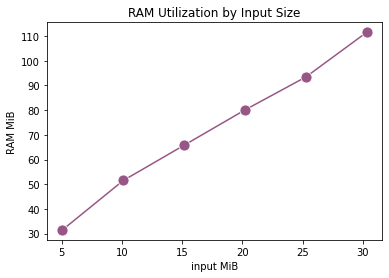

In [33]:
ax = sn.lineplot(data=bytes_time_df, x='input MiB', y='RAM MiB', markersize=11,
marker="o", color="#965786")
ax.set(title='RAM Utilization by Input Size')
fig1 = ax.get_figure()
fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/ram_utilization_jobs.png')
fig1.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/ram_utilization_jobs.pdf')

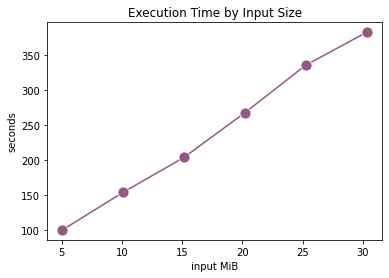

In [34]:
ax = sn.lineplot(data=bytes_time_df, x='input MiB', y='seconds', markersize=11,
marker="o", color="#965786")
ax.set(title='Execution Time by Input Size')
fig2 = ax.get_figure()
fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/execution_by_input_size.png')
fig2.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/execution_by_input_size.pdf')

# Linear regression
## Prediction of time based on input size

In [9]:
data = bytes_time_df
X=data['input MiB'].values.reshape(-1,1)
Y=data['seconds'].values.reshape(-1,1)
linear_reg = sklearn.linear_model.LinearRegression().fit(X,Y)
Y_pred = linear_reg.predict(X)  # make predictions



In [10]:
X

array([[ 5.05605793],
       [10.11211586],
       [15.16817379],
       [20.22423172],
       [25.28028965],
       [30.33634758]])

In [11]:
Y_pred

array([[ 96.19047619],
       [154.04761905],
       [211.9047619 ],
       [269.76190476],
       [327.61904762],
       [385.47619048]])

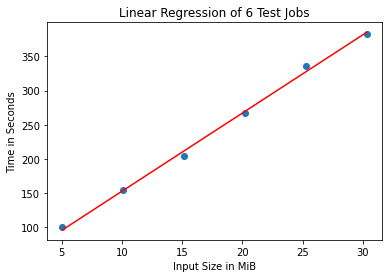

In [12]:
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
# Add title and axis names
plt.title('Linear Regression of 6 Test Jobs')
plt.xlabel('Input Size in MiB')
plt.ylabel('Time in Seconds')
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_time.pdf')
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_time.png')
plt.show()

In [13]:
# Appending value of a real input size that would be used to train a model in a real use case
X_real = X 
X_real = np.append(X_real,200).reshape(-1,1)
X_real

array([[  5.05605793],
       [ 10.11211586],
       [ 15.16817379],
       [ 20.22423172],
       [ 25.28028965],
       [ 30.33634758],
       [200.        ]])

In [14]:
Y_pred_real = linear_reg.predict(X_real)
Y_pred_real

array([[  96.19047619],
       [ 154.04761905],
       [ 211.9047619 ],
       [ 269.76190476],
       [ 327.61904762],
       [ 385.47619048],
       [2326.95991389]])

In [15]:
pwd

'/Users/ila/01_unibo/BDP-projcect-aws-main/stats'

In [16]:
2326.95991389/60

38.7826652315

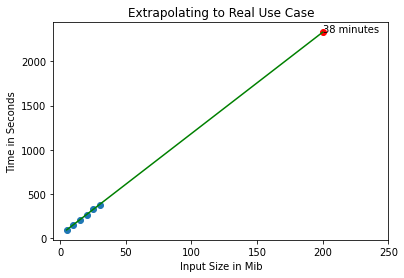

In [39]:
plt.scatter(X, Y)
plt.scatter(200., 2326.95991389, color='red')
# Add label to dot
plt.annotate("38 minutes", (200., 2326.95991389))
plt.plot(X_real, Y_pred_real, color='green') # Marking real use case in red

# Add title and axis names
plt.title('Extrapolating to Real Use Case')
plt.xlabel('Input Size in Mib')
plt.ylabel('Time in Seconds')

# To keep text withing limits of the axes
plt.xlim([-5,250])
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_time_label.pdf')
# plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_time_label.png')
plt.show()

# Source confirms that SVM scale linearly
# https://www.researchgate.net/post/What-is-the-running-time-complexity-of-SVM-and-ANN 

Bottou, Léon, and Chih-Jen Lin. "Support vector machine solvers." Large scale kernel machines (2007): 301-320.

# Linear regression
## Prediction of RAM based on input size

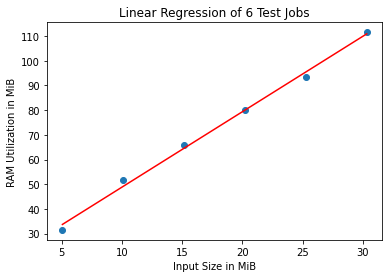

In [46]:
data = bytes_time_df
X=data['input MiB'].values.reshape(-1,1)
Y=data['RAM MiB'].values.reshape(-1,1)
linear_reg = sklearn.linear_model.LinearRegression().fit(X,Y)
Y_pred = linear_reg.predict(X)  # make predictions

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
# Add title and axis names
plt.title('Linear Regression of 6 Test Jobs')
plt.xlabel('Input Size in MiB')
plt.ylabel('RAM Utilization in MiB')
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_ram.pdf')
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/regression_ram.png')
plt.show()



In [36]:
# Appending value of a real input size that would be used to train a model in a real use case
X_real = X 
X_real = np.append(X_real,200).reshape(-1,1)
X_real
Y_pred_real = linear_reg.predict(X_real)
Y_pred_real

array([[ 33.6974    ],
       [ 49.14734   ],
       [ 64.59728   ],
       [ 80.04722   ],
       [ 95.49716   ],
       [110.9471    ],
       [629.39314757]])

In [38]:
X_real

array([[  5.05605793],
       [ 10.11211586],
       [ 15.16817379],
       [ 20.22423172],
       [ 25.28028965],
       [ 30.33634758],
       [200.        ]])

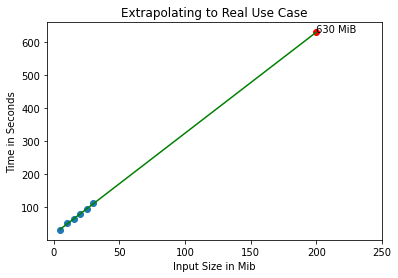

In [42]:
plt.scatter(X, Y)
plt.scatter(200., 629.39314757, color='red')
plt.annotate("630 MiB", (200., 629.39314757))
plt.plot(X_real, Y_pred_real, color='green') # Marking real use case in red
# Add title and axis names
plt.title('Extrapolating to Real Use Case')
plt.xlabel('Input Size in Mib')
plt.ylabel('Time in Seconds')
plt.xlim([-5,20])
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_ram_label.pdf')
plt.savefig('/Users/ila/01_unibo/BDP-projcect-aws-main/stats/extrapolating_ram_label.png')

plt.show()

# Docker Duration

In [2]:
df2 = pd.read_csv('/Users/ila/condor_job_duration_docker', delimiter=" ", header=None)
docker_duration_df = pd.DataFrame(df2.values, columns=["seconds"])
docker_duration_df

,seconds
0,105
1,157
2,214
3,277
4,351
5,397


# Scaling up to gridsearch (10 combinations of C and gamma) crossvalidating producing 50 models

25 worker nodes plus one main node of the same make: 

26 nodes in the cluser


In [1]:
# 2 vCPU in USD
t4g_medium = 0.0336*26 
print("26 t4g.small Machienes ammounting to 50 CPU's cost", t4g_medium, 'USD per hour')

26 t4g.small Machienes ammounting to 50 CPU's cost 0.8735999999999999 USD per hour


In [2]:
min_price = t4g_medium/60

In [3]:
min_price

0.014559999999999998

Given an up time of 1 hr and 16 minutes 

In [4]:
run_time_non_trivial = t4g_medium + (16*min_price)
run_time_non_trivial

1.10656

# This would ammount to a total spending of 1.064 USD

In [5]:
price_per_months_full_cluster = 0.0336*30*26
price_per_months_full_cluster

26.208

In [6]:
st_sp = 50*153
print("The completion of the challeng requres only ", st_sp, "MB storage space.")

The completion of the challeng requres only  7650 MB storage space.


In [ ]:
# 7650